In [268]:
import os, zipfile, math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Read BTCUSDT and ETHUSDT data

In [269]:
# List of symbols to merge
symbols = ['BTCUSDT', 'ETHUSDT']

# List to store individual DataFrames
rawdfs = []

# Loop through each symbol
for symbol in symbols:
    directory = f'../mdt_utils/binance-public-data/python/data/spot/monthly/klines/{symbol}/1h/'
    
    # Loop through each zip file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(directory, file_name), 'r') as zip_ref:
                # only one CSV file in each zip archive
                csv_file = zip_ref.namelist()[0]
                with zip_ref.open(csv_file) as csv_fp:
                    # Read the CSV data into a DataFrame
                    temp_df = pd.read_csv(csv_fp, header=None)
                    temp_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
                    # temp_df['date'] = pd.to_datetime(temp_df['close_time'], unit='ms').dt.strftime('%Y-%m-%d')
                    temp_df = temp_df.rename(columns={"close_time": "time"})
                    temp_df['tic'] = symbol
                    rawdfs.append(temp_df[['time', 'open', 'high', 'low', 'close', 'volume', 'tic']])

# Concatenate all DataFrames into a single DataFrame
rawdf = pd.concat(rawdfs, ignore_index=True)

# Count the number of unique 'tic' values per date
tic_counts = rawdf.groupby('time')['tic'].nunique()

# Filter the DataFrame to keep only rows where all 'tic' values participate
df = rawdf[rawdf['time'].isin(tic_counts[tic_counts == len(rawdf['tic'].unique())].index)]
# Only wanted columns
df = df[['time', 'close', 'tic']]
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

df.sort_values(['time'],ignore_index=True)

time     close      tic                datetime
0       1502945999999    301.61  ETHUSDT 2017-08-17 04:59:59.999
1       1502945999999   4308.83  BTCUSDT 2017-08-17 04:59:59.999
2       1502949599999    303.10  ETHUSDT 2017-08-17 05:59:59.999
3       1502949599999   4315.32  BTCUSDT 2017-08-17 05:59:59.999
4       1502953199999    302.68  ETHUSDT 2017-08-17 06:59:59.999
...               ...       ...      ...                     ...
104025  1690840799999  29243.31  BTCUSDT 2023-07-31 21:59:59.999
104026  1690844399999   1856.40  ETHUSDT 2023-07-31 22:59:59.999
104027  1690844399999  29209.99  BTCUSDT 2023-07-31 22:59:59.999
104028  1690847999999  29232.25  BTCUSDT 2023-07-31 23:59:59.999
104029  1690847999999   1856.14  ETHUSDT 2023-07-31 23:59:59.999

[104030 rows x 4 columns]

In [270]:
STARTDATE = "2023-01-01"

# Binance use ms timestamp
starttime = datetime.strptime(STARTDATE, "%Y-%m-%d").timestamp() * 1000

df = df[df['time'] >= starttime]
df = df.assign(close_log = np.log(df.close))
df.sort_values(['time'],ignore_index=True)

time     close      tic                datetime  close_log
0      1672502399999  16590.10  BTCUSDT 2022-12-31 15:59:59.999   9.716561
1      1672502399999   1202.86  ETHUSDT 2022-12-31 15:59:59.999   7.092457
2      1672505999999  16600.39  BTCUSDT 2022-12-31 16:59:59.999   9.717181
3      1672505999999   1202.79  ETHUSDT 2022-12-31 16:59:59.999   7.092399
4      1672509599999  16582.08  BTCUSDT 2022-12-31 17:59:59.999   9.716078
...              ...       ...      ...                     ...        ...
10185  1690840799999   1856.87  ETHUSDT 2023-07-31 21:59:59.999   7.526648
10186  1690844399999  29209.99  BTCUSDT 2023-07-31 22:59:59.999  10.282266
10187  1690844399999   1856.40  ETHUSDT 2023-07-31 22:59:59.999   7.526394
10188  1690847999999  29232.25  BTCUSDT 2023-07-31 23:59:59.999  10.283028
10189  1690847999999   1856.14  ETHUSDT 2023-07-31 23:59:59.999   7.526254

[10190 rows x 5 columns]

# Check cointegration and correlation

In [271]:
df_btc = df[df['tic']=='BTCUSDT'].sort_values('time',ignore_index=True)
df_eth = df[df['tic']=='ETHUSDT'].sort_values('time',ignore_index=True)

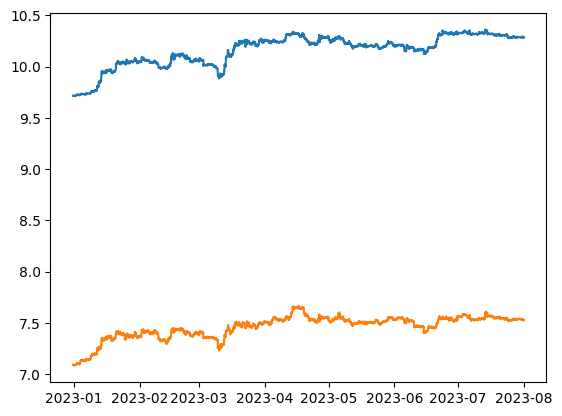

In [273]:
plt.plot(df_btc['datetime'],df_btc['close_log'])
plt.plot(df_btc['datetime'],df_eth['close_log']) 

In [274]:
coint_res = coint(df_btc['close_log'], df_eth['close_log'])
if coint_res[1] > 0.05:
    print(f"the p-value of cointegration test is: ", coint_res[1])
    raise ValueError('BTC and ETH are not cointegrated')
else:
    print('BTC and ETH are cointegrated')

BTC and ETH are cointegrated


Check the correlation

In [275]:
corr_res = np.corrcoef(df_btc['close_log'], df_eth['close_log'])
print("the correlation between BTC and ETH is: ", corr_res[0,1])

the correlation between BTC and ETH is:  0.9688717603105698


# Spread

In [282]:
df_spread = pd.merge(df_btc[['time', 'close', 'close_log', 'datetime']], df_eth[['time', 'close', 'close_log', 'datetime']], on=['time', 'datetime'], how='inner', suffixes=('_btc', '_eth'))
df_spread = df_spread.sort_values(by='time', ignore_index=True)
df_spread

time  close_btc  close_log_btc                datetime  \
0     1672502399999   16590.10       9.716561 2022-12-31 15:59:59.999   
1     1672505999999   16600.39       9.717181 2022-12-31 16:59:59.999   
2     1672509599999   16582.08       9.716078 2022-12-31 17:59:59.999   
3     1672513199999   16577.79       9.715819 2022-12-31 18:59:59.999   
4     1672516799999   16570.14       9.715358 2022-12-31 19:59:59.999   
...             ...        ...            ...                     ...   
5090  1690833599999   29157.48      10.280467 2023-07-31 19:59:59.999   
5091  1690837199999   29208.27      10.282207 2023-07-31 20:59:59.999   
5092  1690840799999   29243.31      10.283406 2023-07-31 21:59:59.999   
5093  1690844399999   29209.99      10.282266 2023-07-31 22:59:59.999   
5094  1690847999999   29232.25      10.283028 2023-07-31 23:59:59.999   

      close_eth  close_log_eth  
0       1202.86       7.092457  
1       1202.79       7.092399  
2       1200.78       7.090727  
3       1199.60       7.089743  
4       1202.65       7.092283  
...         ...            ...  
5090    1856.49       7.526443  
5091    1853.51       7.524836  
5092    1856.87       7.526648  
5093    1856.40       7.526394  
5094    1856.14       7.526254  

[5095 rows x 6 columns]

In [283]:
# only recent three years
df_train = df_spread.head(int(len(df_spread) * 0.8))
df_trade = df_spread.tail(len(df_spread) - len(df_train))
print(f"train start date: {datetime.fromtimestamp(df_train['time'].iloc[0]/1000)}")
print(f"train end date: {datetime.fromtimestamp(df_train['time'].iloc[-1]/1000)}")
print(f"trade start date: {datetime.fromtimestamp(df_trade['time'].iloc[0]/1000)}")
print(f"trade end date: {datetime.fromtimestamp(df_trade['time'].iloc[-1]/1000)}")
df_train

train start date: 2023-01-01 00:59:59.999000
train end date: 2023-06-19 21:59:59.999000
trade start date: 2023-06-19 22:59:59.999000
trade end date: 2023-08-01 08:59:59.999000


time  close_btc  close_log_btc                datetime  \
0     1672502399999   16590.10       9.716561 2022-12-31 15:59:59.999   
1     1672505999999   16600.39       9.717181 2022-12-31 16:59:59.999   
2     1672509599999   16582.08       9.716078 2022-12-31 17:59:59.999   
3     1672513199999   16577.79       9.715819 2022-12-31 18:59:59.999   
4     1672516799999   16570.14       9.715358 2022-12-31 19:59:59.999   
...             ...        ...            ...                     ...   
4071  1687165199999   26417.25      10.181772 2023-06-19 08:59:59.999   
4072  1687168799999   26401.03      10.181158 2023-06-19 09:59:59.999   
4073  1687172399999   26377.99      10.180285 2023-06-19 10:59:59.999   
4074  1687175999999   26447.73      10.182926 2023-06-19 11:59:59.999   
4075  1687179599999   26531.39      10.186084 2023-06-19 12:59:59.999   

      close_eth  close_log_eth  
0       1202.86       7.092457  
1       1202.79       7.092399  
2       1200.78       7.090727  
3       1199.60       7.089743  
4       1202.65       7.092283  
...         ...            ...  
4071    1722.77       7.451689  
4072    1723.91       7.452350  
4073    1721.35       7.450864  
4074    1725.87       7.453487  
4075    1730.74       7.456304  

[4076 rows x 6 columns]

In [284]:
res = stats.linregress(df_train['close_log_eth'], df_train['close_log_btc'])
res

LinregressResult(slope=1.2612330025236165, intercept=0.7374661258913857, rvalue=0.9748010103869348, pvalue=0.0, stderr=0.004521911699265563, intercept_stderr=0.03364140890293149)

In [285]:
df_train = df_train.assign(close_log_btc_hat = df_train['close_log_eth'] * res.slope + res.intercept)
df_train = df_train.assign(spread = df_train['close_log_btc'] - df_train['close_log_btc_hat'])
df_train

time  close_btc  close_log_btc                datetime  \
0     1672502399999   16590.10       9.716561 2022-12-31 15:59:59.999   
1     1672505999999   16600.39       9.717181 2022-12-31 16:59:59.999   
2     1672509599999   16582.08       9.716078 2022-12-31 17:59:59.999   
3     1672513199999   16577.79       9.715819 2022-12-31 18:59:59.999   
4     1672516799999   16570.14       9.715358 2022-12-31 19:59:59.999   
...             ...        ...            ...                     ...   
4071  1687165199999   26417.25      10.181772 2023-06-19 08:59:59.999   
4072  1687168799999   26401.03      10.181158 2023-06-19 09:59:59.999   
4073  1687172399999   26377.99      10.180285 2023-06-19 10:59:59.999   
4074  1687175999999   26447.73      10.182926 2023-06-19 11:59:59.999   
4075  1687179599999   26531.39      10.186084 2023-06-19 12:59:59.999   

      close_eth  close_log_eth  close_log_btc_hat    spread  
0       1202.86       7.092457           9.682707  0.033854  
1       1202.79       7.092399           9.682634  0.034547  
2       1200.78       7.090727           9.680525  0.035553  
3       1199.60       7.089743           9.679285  0.036535  
4       1202.65       7.092283           9.682487  0.032870  
...         ...            ...                ...       ...  
4071    1722.77       7.451689          10.135782  0.045991  
4072    1723.91       7.452350          10.136616  0.044542  
4073    1721.35       7.450864          10.134742  0.045543  
4074    1725.87       7.453487          10.138049  0.044876  
4075    1730.74       7.456304          10.141603  0.044481  

[4076 rows x 8 columns]

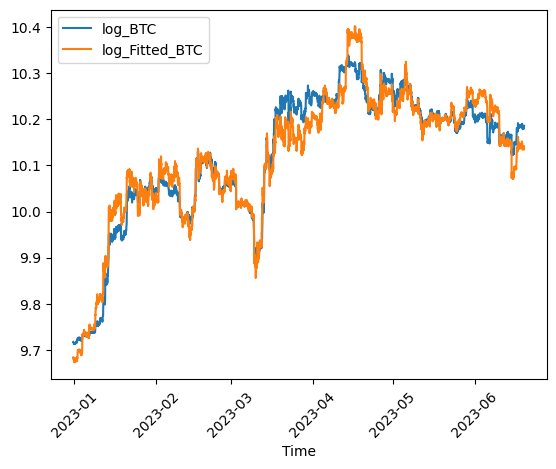

In [289]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot BTC 'close' data with a blue line
ax.plot(df_train['datetime'], df_train['close_log_btc'], label='log_BTC')

# Plot ETH 'close' data with an orange line
ax.plot(df_train['datetime'], df_train['close_log_btc_hat'], label='log_Fitted_BTC')

# # Plot ETH 'close' data with an orange line
# ax.plot(df_train['datetime'], df_train['spread'], label='Spread')

# Set labels and title
ax.set_xlabel('Time')
# ax.set_ylabel('Close Price')

# Show a legend
ax.legend()

# Rotate x-axis labels for better readability (if necessary)
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Stats for spread

In [290]:
df_train = df_train.assign(spread_abs = df_train['spread'].abs())
std = np.std(df_train['spread_abs'])
print(f"spread std: {std}")

spread std: 0.02122515757753686


# Application on the trade data

In [291]:
df_trade = df_trade.assign(close_log_btc_hat = df_trade['close_log_eth'] * res.slope + res.intercept)
df_trade = df_trade.assign(spread = df_trade['close_log_btc'] - df_trade['close_log_btc_hat'])
df_trade.sort_values(by='spread', ignore_index=True)

time  close_btc  close_log_btc                datetime  \
0     1689296399999   31444.01      10.355964 2023-07-14 00:59:59.999   
1     1689299999999   31418.88      10.355164 2023-07-14 01:59:59.999   
2     1689314399999   31360.48      10.353304 2023-07-14 05:59:59.999   
3     1689317999999   31291.22      10.351093 2023-07-14 06:59:59.999   
4     1689310799999   31390.53      10.354262 2023-07-14 04:59:59.999   
...             ...        ...            ...                     ...   
1014  1687985999999   30108.01      10.312547 2023-06-28 20:59:59.999   
1015  1687996799999   30077.41      10.311530 2023-06-28 23:59:59.999   
1016  1688061599999   30543.33      10.326902 2023-06-29 17:59:59.999   
1017  1687989599999   30134.38      10.313422 2023-06-28 21:59:59.999   
1018  1687993199999   30105.94      10.312478 2023-06-28 22:59:59.999   

      close_eth  close_log_eth  close_log_btc_hat    spread  
0       2022.22       7.611951          10.337910  0.018054  
1       2013.56       7.607660          10.332497  0.022667  
2       2008.67       7.605228          10.329431  0.023873  
3       2004.39       7.603095          10.326741  0.024352  
4       2009.16       7.605472          10.329738  0.024523  
...         ...            ...                ...       ...  
1014    1831.60       7.512945          10.213041  0.099506  
1015    1828.02       7.510989          10.210573  0.100957  
1016    1850.40       7.523157          10.225920  0.100981  
1017    1829.84       7.511984          10.211828  0.101594  
1018    1827.80       7.510868          10.210421  0.102057  

[1019 rows x 8 columns]

# Trade

(array([19530., 19539., 19546., 19553., 19560., 19570.]),
 [Text(19530.0, 0, '2023-06-22'),
  Text(19539.0, 0, '2023-07-01'),
  Text(19546.0, 0, '2023-07-08'),
  Text(19553.0, 0, '2023-07-15'),
  Text(19560.0, 0, '2023-07-22'),
  Text(19570.0, 0, '2023-08-01')])

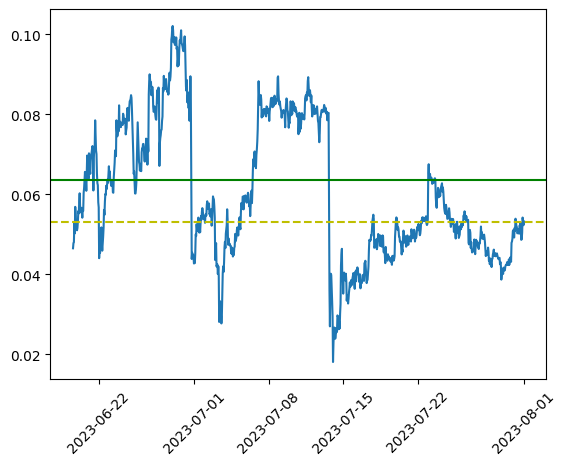

In [294]:
OPEN_THRES = 3
CLOS_THRES = 2.5

# initialise position
position = {
    'time': 0,
    'holding_btc': 0,
    'holding_eth': 0,
    'cash': 0
}

plt.plot(df_trade['datetime'], df_trade['spread'])
plt.axhline(y=std*OPEN_THRES, color='g')
# plt.axhline(y=std*-OPEN_THRES, color='g')
plt.axhline(y=std*CLOS_THRES, color='y', linestyle='--')
# plt.axhline(y=std*-CLOS_THRES, color='y', linestyle='--')

plt.xticks(rotation=45)

In [300]:
arbitrage = []

for index, row in df_trade.iterrows():
    if row['spread'] > std*OPEN_THRES and position['holding_btc'] == 0:
            # sell 1 btc
            position = {
                'holding_btc': -1,
                'holding_eth': row['close_btc']/row['close_eth'],
                'cash': 0,
                'time': row['time'],
                'datetime': row['datetime']
            }
            arbitrage.append(position.copy())
    elif row['spread'] < std*-OPEN_THRES and position['holding_btc'] == 0:
            # buy 1 btc
            position = {
                'holding_btc': 1,
                'holding_eth': -row['close_btc']/row['close_eth'],
                'cash': 0,
                'time': row['time'],
                'datetime': row['datetime']
            }
            arbitrage.append(position.copy())
    elif np.abs(row['spread']) < std*CLOS_THRES and position['holding_btc'] != 0:
            # close position
            position = {
                'holding_btc': 0,
                'holding_eth': 0,
                'cash': row['close_btc'] * position['holding_btc'] + row['close_eth'] * position['holding_eth'],
                'time': row['time'],
                'datetime': row['datetime']
            }
            arbitrage.append(position.copy())

In [301]:
df_arbitrage = pd.DataFrame(arbitrage)
print(f"The total profit is", sum(df_arbitrage['cash']), "USDT")

The total profit is 1524.4992013566916 USDT


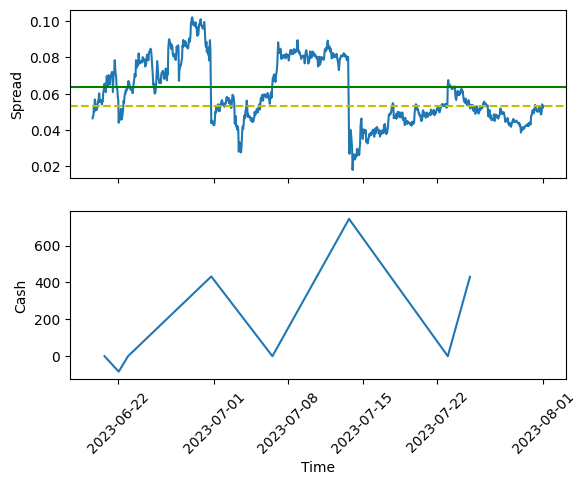

In [302]:
# Assuming df_trade and df_arbitrage have the same 'time' column

# Create a figure with two subplots sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the first line graph on the first subplot (ax1)
ax1.plot(df_trade['datetime'], df_trade['spread'])
ax1.set_ylabel('Spread')  # Set the y-axis label for the first subplot
ax1.axhline(y=std*OPEN_THRES, color='g')
ax1.axhline(y=std*CLOS_THRES, color='y', linestyle='--')

# Plot the second line graph on the second subplot (ax2)
ax2.plot(df_arbitrage['datetime'], df_arbitrage['cash'])
ax2.set_ylabel('Cash')  # Set the y-axis label for the second subplot

# Set a common x-axis label
plt.xlabel('Time')
plt.xticks(rotation=45)

# Show the plot
plt.show()